In [14]:
import os
os.getcwd()

'/Users/Thomas/Desktop/deepreason/gen-sim/mw-pagerank'

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import csv
import torch as th
import importlib
import algorithms.ranker
import algorithms.grad_descent
importlib.reload(algorithms.grad_descent)
importlib.reload(algorithms.ranker)
from algorithms.ranker import Ranker
from algorithms.grad_descent import GradDescent


## Define device for possible GPU or CPU computations

In [2]:
device = 'cuda' if th.cuda.is_available() else 'cpu'

## Preprocessing: Create and store complete company only KG with normalised attributes

In [17]:
FULL_KG_COMP = '../dump/kg/full_company_kg.csv'

G_full = nx.DiGraph()

#Extract data from dump csv file of training data
print('Loading data...')
with open(FULL_KG_COMP, encoding='utf8') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=',', quotechar='\"',
                            fieldnames=["id_organization","uuid","funding_rounds","funding_total_usd",
                                        "employee_count", "filter"])
    next(reader)
    
    #Normalize attributes to have mean 0 and standard deviation of 1, which equalises different computations using model
    funding_rounds = list()
    funding_total = list()
    employee_count = list()
    
    for row in reader:
        funding_rounds.append(float(0) if row["funding_rounds"]=='NULL' else float(row["funding_rounds"]))
        funding_total.append(float(0) if row["funding_total_usd"]=='NULL' else float(row["funding_total_usd"]))
        if '-' in row["employee_count"]:
            count = row["employee_count"].split('-')
            if count[0]=='Nov' or count[1]=='Oct':
                employee_count.append(float(0))
            else:
                avg = (float(count[0])+float(count[1]))/2.
                employee_count.append(avg)
        elif '+' in row["employee_count"]:
            emp_count=float(row["employee_count"].replace('+', ''))
            employee_count.append(emp_count)
        else:
             employee_count.append(float(0))
    
    mean_fund_rounds, var_fund_rounds = np.mean(funding_rounds), np.var(funding_rounds)
    mean_fund_tot, var_fund_tot = np.mean(funding_total), np.var(funding_total)
    mean_emp_count, var_emp_count = np.mean(employee_count), np.var(employee_count)
    
    
print('Loading nodes...')
#Now iterate through reader object once more, creating full graph with normalised attributes
with open(FULL_KG_COMP, encoding='utf8') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=',', quotechar='\"',
                            fieldnames=["id_organization","uuid","funding_rounds","funding_total_usd",
                                        "employee_count", "filter"])
    next(reader)
    
    #Subdivision into Spectrum list/Random company nodes
    dest_nodes = list()
    no_link_nodes = list()  
    
    it = 0
    for row in reader:
        if it < 10000:
            pass
        else:
            break
        if '-' in row["employee_count"]:
            count = row["employee_count"].split('-')
            if count[0]=='Nov' or count[1]=='Oct':
                emp_count = float(0)
            else:
                avg = (float(count[0])+float(count[1]))/2.
                emp_count = (avg-mean_emp_count)/np.sqrt(var_emp_count)
        elif '+' in row["employee_count"]:
            emp_count=(float(row["employee_count"].replace('+', ''))-mean_emp_count)/np.sqrt(var_emp_count)
        else:
            emp_count = float(0)
        
        G_full.add_node(row["uuid"],
                    type="Company",
                    id=int(row["id_organization"]),
                    funding_rounds=0 if row["funding_rounds"]=='NULL' or None else (float(row["funding_rounds"])-mean_fund_rounds)/np.sqrt(var_fund_rounds),
                    funding_total_usd=0 if row["funding_total_usd"]=='NULL' or None else (float(row["funding_total_usd"])-mean_fund_tot)/np.sqrt(var_fund_tot),
                    employee_count=emp_count)
        
        #Subdivide nodes into positive 'bias' nodes and negative no-link nodes
        if row["filter"]==str(1):
            dest_nodes.append(row["uuid"])
        else:
            no_link_nodes.append(row["uuid"])
            
        it+=1
            
print('{} destination nodes and {} negative nodes loaded'.format(len(dest_nodes), len(no_link_nodes)))
print('Loading edges...')

#Add egdes between a company and 10 randomly selected companies (as test for method)
nodes = list(G_full.nodes(data=True))
row=0
for i in G_full.nodes(data=True):
    for j in range(100):
        rand = random.randint(0, len(G_full.nodes)-1)
        v = nodes[rand]
        G_full.add_edge(i[0], v[0], funding_rounds_1=i[1]["funding_rounds"],
            funding_rounds_2=v[1]["funding_rounds"], funding_total_usd_1=i[1]["funding_total_usd"],
            funding_total_usd_2=v[1]["funding_total_usd"], employee_count_1=i[1]["employee_count"],
            employee_count_2=v[1]["employee_count"])
    row+=1
    if row%10000==0:
        print('edges for {} nodes loaded'.format(row))
    
print('Loaded {0} nodes'.format(len(G_full.nodes)))
print('Loaded {0} edges'.format(nx.number_of_edges(G_full)))

Loading data...
Loading nodes...
599 destination nodes and 9401 negative nodes loaded
Loading edges...
Loaded 9999 nodes
Loaded 995047 edges


### From full company KG, extract training data in the form of an ordered subgraph: starting with 250 positive example nodes, selected from Spectrum list, following 250 negative example nodes, selected randomly from remaining KG.

In [8]:
numb_spectrum = len(dest_nodes)
numb_rest = len(no_link_nodes)
ntrain = int(500)

train_nodes = list()

random_seed_pos = random.sample(range(0, numb_spectrum), 250)
random_seed_neg = random.sample(range(0, numb_rest), 250)

while len(random_seed_pos) < 250:
    rand = random.randint(0, numb_spectrum-1)
    if rand in random_seed_pos:
        pass
    else:
        random_seed_pos.append(rand)
while len(random_seed_neg) < 250:
    rand = random.randint(0, numb_rest-1)
    if rand in random_seed_neg:
        pass
    else:
        random_seed_neg.append(rand)

for i in random_seed_pos:
    train_nodes.append(dest_nodes[i])
for i in random_seed_neg:
    train_nodes.append(no_link_nodes[i])

G_train = G_full.subgraph(train_nodes)
print('Loaded {0} training nodes'.format(len(G_train.nodes)))
print('Loaded {0} training edges'.format(nx.number_of_edges(G_train)))

Loaded 500 training nodes
Loaded 4902 training edges


## Generate feature matrix and adjacency matrix from KG
### Create feature matrix with inherent graph structure taken into account (i.e. when no edge exists between two nodes a null feature vector is associated with the edge in the matrix)

In [4]:
def gen_feature_matrix(G, nnodes, nfeats, device):
    #Instantiate feature matrix with correct shape
    feature_matrix = th.zeros(nnodes, nnodes, nfeats, dtype=th.float, device=device)
    
    #Add relevant feature vectors
    nodes = list(G)
    nodes_i = {nodes[i]: i for i in range(len(nodes))}
    for u in nodes:
        v_n = set(G.successors(u))
        for v in v_n:
            feat_vect = list()
            feat_vect.append(G[u][v]["funding_rounds_1"])
            feat_vect.append(G[u][v]["funding_rounds_2"])
            feat_vect.append(G[u][v]["funding_total_usd_1"])
            feat_vect.append(G[u][v]["funding_total_usd_2"])
            feat_vect.append(G[u][v]["employee_count_1"])
            feat_vect.append(G[u][v]["employee_count_2"])
            ind_u = nodes_i[u]
            ind_v = nodes_i[v]
            feat_vect = th.tensor(feat_vect, dtype=th.float, device=device)
            feature_matrix[ind_u,ind_v]=feat_vect

    return feature_matrix

#Create adjacenecy matrix supported by Pytorch 
def gen_adj_matrix(G, nnodes, nfeats, device):
    adj_matrix = nx.to_numpy_matrix(G)
    adj_matrix = th.tensor(adj_matrix, dtype=th.float, device=device)
    return adj_matrix

## Perform supervised random walk with restarts on training data to compute optimised weights
### where G_train is the training graph and N is the limiting index denoting that the first N nodes of the training set consists of positive 'bias' nodes (and the rest are negative 'no-link' nodes), for every  source node in the algorithm. 

In [24]:
def rand_walker(G_train, limit_ind, device):
    nnodes = len(G_train.nodes)
    nfeats = int(6)
    
    #Instantiate training set
    train_feat = gen_feature_matrix(G_train, nnodes, nfeats, device)
    
    print('Loading optimised weights...')
    bias_train = GradDescent(train_feat, device, limit_ind)
    opt_weights = bias_train.grad_iterator()
    print('Optimised weights are {}'.format(opt_weights))
    
    return opt_weights

limit_ind = 250
opt_weights = rand_walker(G_train, limit_ind, device)

Loading optimised weights...
Epoch=0, f_w=tensor([-1.3891], grad_fn=<AddBackward0>), weights=tensor([0., 0., 0., 0., 0., 0.], requires_grad=True), grad=tensor([-29.6975, 262.1623, -16.0228,  46.1123,  33.0193, -26.5451]) (27.850332021713257s)
Epoch=1, f_w=tensor([-69.1064], grad_fn=<AddBackward0>), weights=tensor([ 0.0594, -0.5243,  0.0320, -0.0922, -0.0660,  0.0531],
       requires_grad=True), grad=tensor([-114.9421,   49.3165,  -38.2113,    3.0204,   12.0980,  -79.4680]) (26.072743892669678s)
Epoch=2, f_w=tensor([-277.7714], grad_fn=<AddBackward0>), weights=tensor([ 0.3427, -1.0948,  0.1373, -0.1813, -0.1497,  0.2598],
       requires_grad=True), grad=tensor([-715.5901,  110.4926, -163.5978,    7.5615,   -3.7645, -762.0476]) (24.114773988723755s)
Epoch=3, f_w=tensor([-5106.0459], grad_fn=<AddBackward0>), weights=tensor([ 2.0289, -1.8293,  0.5592, -0.2765, -0.2174,  1.9699],
       requires_grad=True), grad=tensor([-420.6210,  212.3301,  -98.3852,   51.3088,   30.6344,    1.7112]) (2

## Now examine similarity ranking for the whole company KG, computed using optimised weights

Loading full graph feature matrix...
Loading full graph PageRank with optimised weights...
Loading graph of similarity ranking...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


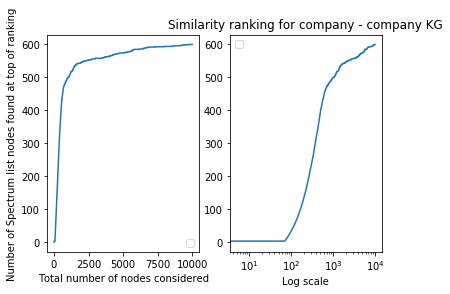

In [18]:
print('Loading full graph feature matrix...')
all_nnodes = len(G_full.nodes)
all_nfeats = int(6)
full_feat_matrix = gen_feature_matrix(G_full, all_nnodes, all_nfeats, device)

print('Loading full graph PageRank with optimised weights...')
source_node = random.randint(0, all_nnodes-1)
opt_weights = th.tensor([ 3.4088, -1.2349, -2.2977, -4.1775,  3.2512,  1.4724], dtype=th.float, device=device)
full_ranker = Ranker(all_nnodes, all_nfeats, opt_weights, full_feat_matrix, device)
full_rw_matrix = full_ranker.rw_matrix()
p_scores = full_ranker.rwr_iter(full_rw_matrix, source_node) 
p_scores = th.squeeze(p_scores)

#Order PR scores
scores_i = {i: p_scores[i] for i in range(all_nnodes)}
new_ranking = sorted(scores_i, key=scores_i.get, reverse=True)

print('Loading graph of similarity ranking...')
#Check graph of bias nodes
step = 0
steps = []
intersection = []
bias_nodes = set(range(numb_spectrum))
while step < all_nnodes:
    steps.append(step)
    top_scores = len(set(new_ranking[:step]).intersection(bias_nodes))
    intersection.append(top_scores)
    step += 5

#Plot graph
fig, axes = plt.subplots(1, 2)

axes[0].plot(steps, intersection)
axes[1].plot(steps, intersection)

axes[0].legend(loc='lower right')
axes[0].set_xlabel('Total number of nodes considered')
axes[0].set_ylabel('Number of Spectrum list nodes found at top of ranking')
axes[1].set_title('Similarity ranking for company - company KG')
axes[1].set_xlabel('Log scale')
axes[1].legend(loc='upper left')
axes[1].set_xscale('log')
plt.show()

In [ ]:
test weights: [ 2.8570, -1.2716, -0.5069, -1.5464,  0.5123,  2.2788]